# Example for the Text Siamese model

Concept is the same as other siameses models : use a model\* to embed text and compare their embeddings to determine whether they belong to the same class or not. However, in this notebook, the concept of *class* is not really relevant\*\* so the model will compare sentence meanings (whether 2 inputs tells the same thing or not). 

Currently, this model has not many features compared to the `AudioSiamese` but it will be improved in future updates.

Indeed, `text embedding` can be usefull for other topics such as `Question Answering (Q&A)` (for question / context encoding for instance).
However this method has not been tested yet so I do not know if it will work or not : surprise ! :D All results, codes and models will be shared in next updates ;)

\* The model used is a classical *Language Modeling (ML)* model (BERT in this case) augmented by some layers for embedding the BERT's output.

\*\* It is my choice to make *text meaning similarity* but you can base comparison on classes such as *emotion prediction*, *topic prediction*, or even *writer classification* !

Note : the trained model shared and presented in this notebook is my 2nd experiment and **not** my final / usable model, it will be refined in future updates ;) 

Furthermore, I made a small mistake in its *text encoder* which did not lowercase the text. The `Evaluation` shows an evaluation on *valid set* with the modification and, surprisingly, it just lost 3% accuracy. 

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from models.siamese import TextSiamese
from utils.text import TextEncoder
from utils import plot, plot_multiple, plot_embedding, plot_confusion_matrix, set_display_options, sample_df
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time

set_display_options()

model_name = 'text_siamese_512'
bert_base  = 'bert-base-uncased'

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.10.0


In [2]:
config = {
    'lang'             : 'en',
    'embedding_dim'    : 512,
    'max_input_length' : 512,
    'use_fixed_length_input' : False,
    
    'text_encoder' : bert_base,
    
    'normalize'  : True,
    'pretrained' : bert_base,
    'output_layer_type' : 'bi_lstm',
    'output_layer_kwargs' : {'return_sequences' : True},
    'final_pooling'     : ['max', 'avg'],
    'use_final_dense'   : True
}

model = TextSiamese(nom = model_name, ** config)

print(model)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Variable bert_embedding/output/output_layer/kernel:0 from layer bert_embedding/output/output_layer does not have any mapping : re-using its current weights
Variable bert_embedding/output/output_layer/bias:0 from layer bert_embedding/output/output_layer does not have any mapping : re-using its current weights
Weights transfered successfully !
Encoder is not a `tf.keras.Sequential` so you have to handle `normalize` internally !
Initializing model with kwargs : {'siamese': {'architecture_name': 'siamese', 'model': <custom_architectures.transformers_arch.bert_arch.BertEmbedding object at 0x0000018F43E1D160>, 'distance_metric': 'euclidian', 'input_signature': (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))}}
Initializing submodel : `siamese` !
Submodel siamese saved in pretrained_models\text_siamese_512\saving\siamese.json !
Model text_siamese_512 initialized successfully !

========== text_siamese_512 ==========
Sub model si

In [3]:
model.summary()
model.encoder.summary()
model.decoder.summary()


========== Summary of siamese ==========

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a_0 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_a_1 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
input_b_0 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_b_1 (InputLayer)          [(None,)]            0                                            
__________________________________________

## Model instanciation + dataset loading

In [2]:
model = TextSiamese(nom = model_name)

#model.compile(
#    optimizer = 'adam', 
#    optimizer_config = {
#        'lr' : {'name' : 'WarmupScheduler', 'maxval' : 1e-3,'minval' : 1e-4, 'factor' : 256, 'warmup_steps' : 4096}
#    }
#)
model.compile(optimizer = 'adam')
print(model)

Model restoration...
Successfully restored siamese from pretrained_models/text_siamese_512/saving/siamese.json !
Model text_siamese_512 initialized successfully !
Optimizer 'siamese_optimizer' initilized successfully !
Submodel siamese compiled !
  Loss : {'reduction': 'auto', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}, {'name': 'EER', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'thresholds': [0.005025125628140704, 0.010050251256281407, 0.01507537688442211, 0.020100502512562814, 0.02512562814070352, 0.03015075376884422, 0.035175879396984924, 0.04020100502512563, 0.04522613065326633, 0.05025125628140704, 0.05527638190954774, 0.06030150753768844, 0.06532663316582915, 0.07035175879396985, 0.075

In [3]:
datasets = 'snli'

dataset = get_dataset(datasets)
train, valid = dataset['train'], dataset['valid']


print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)
))

Loading dataset snli...
Dataset length :
  Training set : 549361
  Validation set : 9842


## Training

In [8]:
epochs = 15
batch_size = 64
shuffle_size = batch_size * 64

print("Training samples   : {} - {} batches".format(len(train), len(train) // batch_size))
print("Validation samples : {} - {} batches".format(len(valid), len(valid) // (batch_size * 2)))

model.siamese.get_layer('bert_embedding').freeze(trainable = False)

hist = model.train(
    train, validation_data = valid, 
    epochs = epochs, batch_size = batch_size, valid_batch_size = 2.,
    shuffle_size = shuffle_size
)

Training samples   : 549361 - 8583 batches
Validation samples : 9842 - 76 batches
Training config :
HParams :
- augment_prct	: 0.25
- epochs	: 30
- batch_size	: 64
- valid_batch_size	: 2.0
- test_batch_size	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 4096

Epoch 16/30
   2866/Unknown - 1885s 658ms/step - loss: 0.2884 - siamese_BinaryAccuracy: 0.8843 - EER: 0.1161 - AUC: 0.9496
Saving at epoch 16 !

Making prediction at step 45856
2866/2866 [==============================] - 1939s 677ms/step - loss: 0.2884 - siamese_BinaryAccuracy: 0.8843 - EER: 0.1161 - AUC: 0.9496 - val_loss: 0.3517 - val_siamese_BinaryAccuracy: 0.8543 - val_EER: 0.1526 - val_AUC: 0.9162
Epoch 17/30
2866/2866 [==============================] - ETA: 0s - loss: 0.2762 - siamese_BinaryAccuracy: 0.8922 - EER: 0.1115 - AUC: 0.9542
Making prediction at step 48722
2866/2866 [==============================] - 1920s 670ms/step -

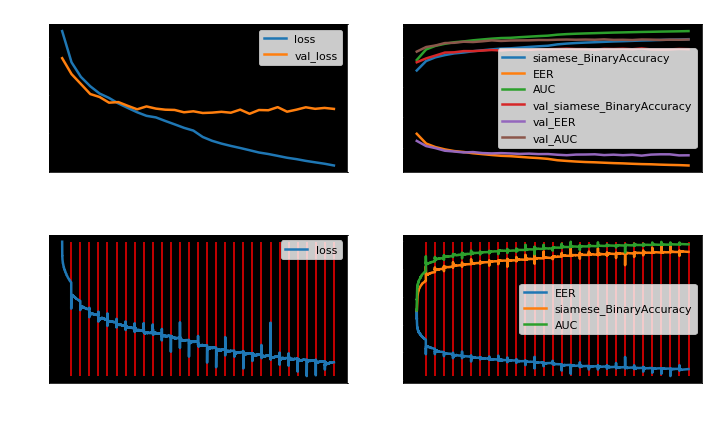

===== History =====
         AUC       EER      loss  siamese_BinaryAccuracy   val_AUC   val_EER  val_loss  val_siamese_BinaryAccuracy
0   0.781572  0.291856  0.568147                0.711822  0.837055  0.244518  0.496633                    0.766348
1   0.851455  0.226967  0.485682                0.774781  0.867431  0.210123  0.454535                    0.791956
2   0.875345  0.203163  0.447108                0.799411  0.877874  0.196455  0.428280                    0.811053
3   0.888949  0.188099  0.422309                0.813959  0.893856  0.179183  0.401784                    0.830729
4   0.899313  0.176988  0.403063                0.825167  0.895614  0.174076  0.393960                    0.832465
5   0.904751  0.170846  0.391535                0.831151  0.902812  0.167768  0.378984                    0.840422
6   0.912120  0.162564  0.376991                0.839676  0.900677  0.170321  0.380518                    0.840278
7   0.917721  0.156618  0.365124                0.845742  0.

In [4]:
model.plot_history()
print(model.history)

## Evaluation

In [ ]:
model.test(valid)

## Prediction

In [4]:
for idx, row in valid.sample(10, random_state = 0).iterrows():
    inp_x = {k[:-2] : row[k] for k in row.index if k.endswith('_x')}
    inp_y = {k[:-2] : row[k] for k in row.index if k.endswith('_y')}
    
    embed_x = model.embed(inp_x)
    embed_y = model.embed(inp_y)
    
    simi = model.pred_similarity(embed_x, embed_y)
    
    print("Similarity : {:.2f} % (target : {})\n  Sentence x : {}\n  Sentence y : {}\n".format(
        np.squeeze(simi) * 100, row['label'], inp_x['text'], inp_y['text']
    ))


Similarity : 96.22 % (target : entailment)
  Sentence x : The tiny girl dressed in a butterfly ballet costume, waves her wand near a nutcracker statue.
  Sentence y : A small girl dances ballet.

Similarity : 90.62 % (target : neutral)
  Sentence x : A boat docked on a river.
  Sentence y : The boat is a fishing boat.

Similarity : 96.71 % (target : entailment)
  Sentence x : Two horses, one black and one brown, are pulling a man outside.
  Sentence y : A man is with two animals.

Similarity : 97.09 % (target : neutral)
  Sentence x : A man in a gray long-sleeved shirt is making a transaction with another person from his street market.
  Sentence y : A man is trying to sell his bowling ball collection

Similarity : 91.17 % (target : entailment)
  Sentence x : A old man sells hardware parts on a dirty sidewalk.
  Sentence y : The man is outside.

Similarity : 99.93 % (target : neutral)
  Sentence x : A baseball player sliding toward second base.
  Sentence y : A tall baseball player sli

## Confusion matrix

<Figure size 360x360 with 0 Axes>

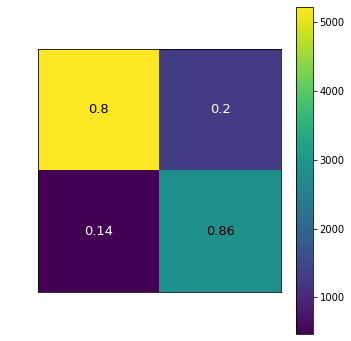

In [6]:
inp_x = valid[[col for col in valid.columns if col.endswith('_x')]]
inp_y = valid[[col for col in valid.columns if col.endswith('_y')]]

inp_x = inp_x.rename({k : k[:-2] for k in inp_x.columns}, axis = 'columns')
inp_y = inp_y.rename({k : k[:-2] for k in inp_y.columns}, axis = 'columns')

emb_x = model.embed(inp_x)
emb_y = model.embed(inp_y)

simi = model.pred_similarity(emb_x, emb_y)

plot_confusion_matrix(pred = tf.cast(simi > 0.5, tf.int32), true = valid['same'].values.astype(np.int32), figsize = (5, 5))

## Tests

In [4]:
config = model.get_dataset_config(batch_size = 16, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(train, ** config, debug = True)

test_dataset_time(ds, steps = 50)

Original dataset : <ZipDataset shapes: ({label: (), text_x: (), text_y: (), same: ()}, {label: (), text_x: (), text_y: (), same: ()}), types: ({label: tf.string, text_x: tf.string, text_y: tf.string, same: tf.bool}, {label: tf.string, text_x: tf.string, text_y: tf.string, same: tf.bool})>
- Dataset after encoding : <ParallelMapDataset shapes: (((((None,), ()), ((None,), ())), ()), ((((None,), ()), ((None,), ())), ())), types: ((((tf.int32, tf.int32), (tf.int32, tf.int32)), tf.int32), (((tf.int32, tf.int32), (tf.int32, tf.int32)), tf.int32))>
- Dataset after filtering : <FilterDataset shapes: (((((None,), ()), ((None,), ())), ()), ((((None,), ()), ((None,), ())), ())), types: ((((tf.int32, tf.int32), (tf.int32, tf.int32)), tf.int32), (((tf.int32, tf.int32), (tf.int32, tf.int32)), tf.int32))>
- Dataset after augmentation : <ParallelMapDataset shapes: (((((None,), ()), ((None,), ())), ()), ((((None,), ()), ((None,), ())), ())), types: ((((tf.int32, tf.int32), (tf.int32, tf.int32)), tf.int

49it [00:01, 43.88it/s]


50 batchs in 1.120 sec sec (44.650 batch / sec)
Batch infos : 
Element 0 : 
 Element 0 : 
  Element 0 : shape : (32, 32) - type : <dtype: 'int32'> - min : 0.000 - max : 29195.000
  Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 10.000 - max : 32.000
 Element 1 : 
  Element 0 : shape : (32, 24) - type : <dtype: 'int32'> - min : 0.000 - max : 29515.000
  Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 6.000 - max : 24.000
Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 0.000 - max : 1.000


1.1198177337646484

In [ ]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 1e-3, minval = 1e-4, factor = 256, warmup_steps = 4096)
lr.plot(25000)

In [6]:
lr = model.get_optimizer().learning_rate
lr.assign(5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0005>

In [7]:
lr = model.get_optimizer().learning_rate
print(lr)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
